In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GroupNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
train_data_dir = '/content/drive/MyDrive/MRI/Training'
test_data_dir = '/content/drive/MyDrive/MRI/Testing'

In [ ]:
train_features = []
train_labels = []

In [ ]:
test_features = []
test_labels = []

In [ ]:
def extract_features(directory):
    features = []
    labels = []

    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)

        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)


                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)


                features_batch = base_model.predict(img_array)
                features.append(features_batch.flatten())


                labels.append(class_label)

    return np.array(features), np.array(labels)


In [ ]:
train_features, train_labels = extract_features(train_data_dir)


In [ ]:
test_features, test_labels = extract_features(test_data_dir)

In [ ]:
print("Training Feature matrix shape:", train_features.shape)
print("Training Labels shape:", train_labels.shape)


In [ ]:
print("Testing Feature matrix shape:", test_features.shape)
print("Testing Labels shape:", test_labels.shape)

In [ ]:
base_model.summary()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
Training Feature matrix shape: (5712, 100352)
Training Labels shape: (5712,)
Testing Feature matrix shape: (1311, 100352)
Testing Labels shape: (1311,)
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                  

In [ ]:
def count_images_in_folder(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    return len(files)

def count_images_in_path(path):
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    count_dict = {}
    for folder in folders:
        folder_path = os.path.join(path, folder)
        count = count_images_in_folder(folder_path)
        count_dict[folder] = count
    return count_dict

In [ ]:
training_path ='/content/drive/MyDrive/MRI/Training'
testing_path = '/content/drive/MyDrive/MRI/Testing'

In [ ]:
train_counts = count_images_in_path(training_path)
test_counts = count_images_in_path(testing_path)

In [ ]:
total_counts = {key: train_counts.get(key, 0) + test_counts.get(key, 0) for key in set(train_counts) | set(test_counts)}


In [ ]:
quantity_total = pd.DataFrame(index=range(0, len(total_counts)), columns=['class', 'count'])


In [ ]:
quantity_total['class'] = list(total_counts.keys())
quantity_total['count'] = list(total_counts.values())

In [ ]:
print("Total number of images:")
print(quantity_total)


Total number of images:
        class  count
0     notumor   2000
1   pituitary   1757
2  meningioma   1645
3      glioma   1621


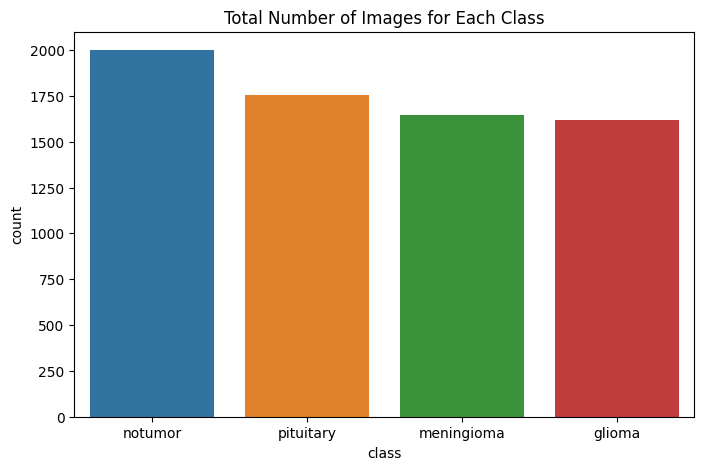

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='class', y='count', data=quantity_total)
plt.title('Total Number of Images for Each Class')
plt.show()

In [ ]:
def get_sample_images(folder_path, num_samples=1):
    sample_images = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        sample_images[class_folder] = image_files[:num_samples]

    return sample_images

In [ ]:
def plot_sample_images(folder_path, sample_images):
    num_classes = len(sample_images)
    num_samples = len(list(sample_images.values())[0])

In [ ]:
num_rows = (num_classes + 1) // 2
num_cols = 2

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
fig.suptitle('Sample Images from Each Class')

In [ ]:
    for i, (class_name, images) in enumerate(sample_images.items()):
        row = i // num_cols
        col = i % num_cols

        for j, image in enumerate(images):
            image_path = os.path.join(folder_path, class_name, image)
            ax = axes[row, col]
            img = mpimg.imread(image_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name)

In [ ]:
for i in range(num_classes, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.show()

In [ ]:
data_path = '/content/drive/MyDrive/MRI/Training'

In [ ]:
sample_images = get_sample_images(data_path, num_samples=1)

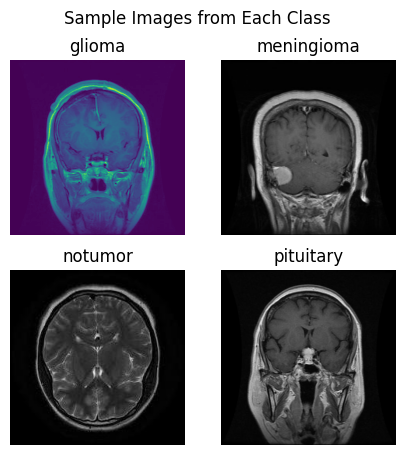

In [ ]:
plot_sample_images(data_path, sample_images)

In [ ]:
num_classes = 4

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


In [ ]:
model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer 5
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer 6
model.add(layers.Flatten())

# Layer 7
model.add(layers.Dense(256, activation='relu'))

# Layer 8
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))

adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
model = Sequential()

In [ ]:
# Layer 1
model.add(Conv2D(64, (7, 7), input_shape=(150, 150, 3), padding='same', activation='relu'))
model.add(GroupNormalization(groups=16, axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model.add(GroupNormalization(groups=16, axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model.add(GroupNormalization(groups=16, axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(Conv2D(256, (7, 7), padding='same', activation='relu'))
model.add(GroupNormalization(groups=16, axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(Conv2D(256, (7, 7), padding='same', activation='relu'))
model.add(GroupNormalization(groups=16, axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (7, 7), padding='same', activation='relu'))
model.add(GroupNormalization(groups=16, axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with Adam optimizer and learning rate of 0.001
adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
y_pred = model.predict(test_generator)
y_true = np.argmax(test_generator.classes, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes), [f'Class {i}' for i in range(num_classes)])
plt.yticks(np.arange(num_classes), [f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(num_classes, activation='softmax'))

adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
y_pred = model.predict(test_generator)
y_true = np.argmax(test_generator.classes, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes), [f'Class {i}' for i in range(num_classes)])
plt.yticks(np.arange(num_classes), [f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
train_features = []
train_labels = []

In [ ]:
test_features = []
test_labels = []

In [ ]:
def extract_features(directory):
    features = []
    labels = []

    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            features_batch = base_model.predict(img_array)
            features.append(features_batch.flatten())
            labels.append(class_label)

    return np.array(features), np.array(labels)

In [ ]:
train_features, train_labels = extract_features(train_data_dir)

In [ ]:
test_features, test_labels = extract_features(test_data_dir)

In [ ]:
print("Training Feature matrix shape:", train_features.shape)
print("Training Labels shape:", train_labels.shape)
print("Testing Feature matrix shape:", test_features.shape)
print("Testing Labels shape:", test_labels.shape)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Training Feature matrix shape: (5712, 100352)
Training Labels shape: (5712,)
Testing Feature matrix shape: (1311, 100352)
Testing Labels shape: (1311,)


In [ ]:
unique_train_labels = np.unique(train_labels)
print("Unique labels for training data:", unique_train_labels)
unique_test_labels = np.unique(test_labels)
print("Unique labels for testing data:", unique_test_labels)

Unique labels for training data: ['glioma' 'meningioma' 'notumor' 'pituitary']
Unique labels for testing data: ['glioma' 'meningioma' 'notumor' 'pituitary']


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
latent_dim = 100
img_shape = (224, 224, 3)

In [ ]:
generator = Sequential()
generator.add(Dense(128 * 56 * 56, input_dim=latent_dim))
generator.add(Reshape((56, 56, 128)))
generator.add(Dense(256, activation='relu'))
generator.add(Dense(3, activation='sigmoid'))

In [ ]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=(56, 56, 3)))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')


In [ ]:
epochs = 10000
batch_size = 32

history = {"discriminator_loss": [], "generator_loss": []}

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    real_images, _ = next(datagen.flow_from_directory(train_data_dir, target_size=(56, 56), batch_size=batch_size, class_mode='binary'))

In [ ]:
    discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
    discriminator_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

In [ ]:
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    generator_loss = gan.train_on_batch(noise, valid_labels)

In [ ]:
    history["discriminator_loss"].append(discriminator_loss[0])
    history["generator_loss"].append(generator_loss)

In [ ]:
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

In [ ]:
num_generated_images = 4
noise = np.random.normal(0, 1, (num_generated_images, latent_dim))
generated_images = generator.predict(noise)

Streaming output truncated to the last 5000 lines.
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 15ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 15ms/step
Found 5712 images belonging to 4 classes.
Epoch 7500, Discriminator Loss: 0.7149016857147217, Generator Loss: 0.7954946160316467
1/1 [==============================] - 0s 15ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 18ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 15ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 15ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 16ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 15ms/step
Found 5712 images belonging to 4 classes.
1/1 [==============================] - 0s 15ms/step
Found 5712 image

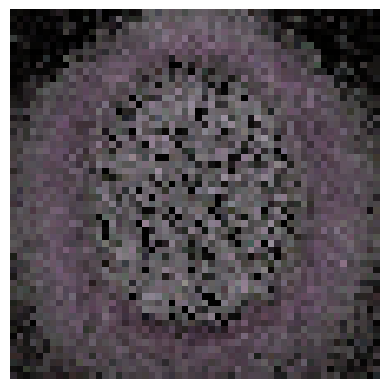

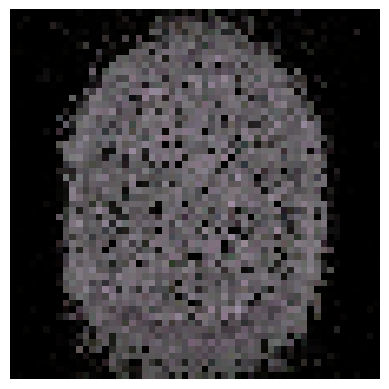

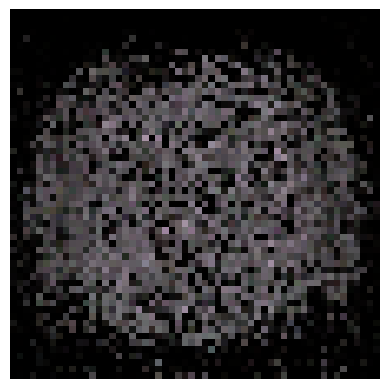

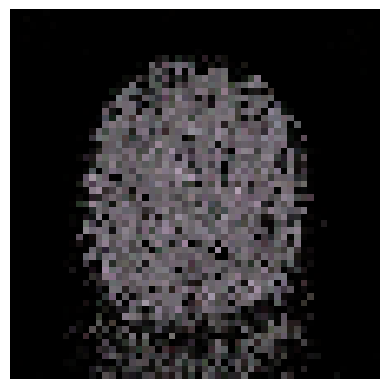

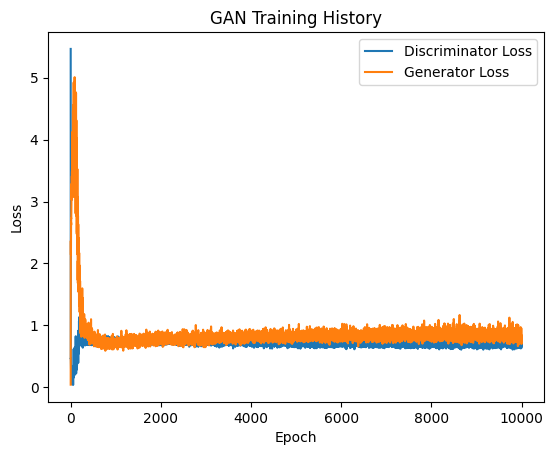

In [ ]:
for i in range(num_generated_images):
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.show()
plt.plot(history["discriminator_loss"], label="Discriminator Loss")
plt.plot(history["generator_loss"], label="Generator Loss")
plt.title("GAN Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
img_size = (224, 224)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32
)

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_predictions = model.predict(train_generator)
train_pred_classes = np.argmax(train_predictions, axis=1)
train_true_classes = train_generator.classes
train_accuracy = accuracy_score(train_true_classes, train_pred_classes)

In [ ]:
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)

In [ ]:
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

In [ ]:
confusion_mtx = confusion_matrix(test_true_classes, test_pred_classes)

In [ ]:
class_labels = list(train_generator.class_indices.keys())
classification_rep = classification_report(test_true_classes, test_pred_classes, target_names=class_labels)

In [ ]:
print("Confusion Matrix:")
print(confusion_mtx)
print("\nClassification Report:")
print(classification_rep)

### VGG-19

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

In [ ]:
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

In [ ]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg19.trainable = False

In [ ]:
_input = Input(shape=(224, 224, 3))
x = vgg19(_input, training=False)
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
output = Dense(train_generator.num_classes, activation="softmax")(x)  # Adjusted output layer to match the number of classes

model = Model(inputs=_input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print("Model Summary:\n")
model.summary()

In [ ]:
history_vgg19 = model.fit(train_generator, epochs=50, validation_data=test_generator)


In [ ]:
final_train_accuracy = history_vgg19.history['accuracy'][-1]
final_test_accuracy = history_vgg19.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy*100:.2f}%")

In [ ]:
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_vgg19.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg19.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/MRI_Data_Analysis/vgg19_model'
model.save(model_save_path)

In [ ]:
model = load_model(model_save_path)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/MRI_Data_Analysis/vgg19_model'
model = load_model(model_path)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
true_binary = to_categorical(true_classes, num_classes=train_generator.num_classes)
predicted_binary = to_categorical(predicted_classes, num_classes=train_generator.num_classes)

In [ ]:
hamming_loss_value = hamming_loss(true_binary, predicted_binary)
matthews_corrcoef_value = matthews_corrcoef(true_classes, predicted_classes)
jaccard_score_value = jaccard_score(true_binary, predicted_binary, average='macro')
cohen_kappa_score_value = cohen_kappa_score(true_classes, predicted_classes)

In [ ]:
print(f"Hamming Loss: {hamming_loss_value}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef_value}")
print(f"Jaccard Score: {jaccard_score_value}")
print(f"Cohen's Kappa: {cohen_kappa_score_value}")

### VGG-16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


In [ ]:
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

In [ ]:
_input = Input(shape=(224, 224, 3))

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(train_generator.num_classes, activation="softmax")(dense2)  # Adjusted output layer to match the number of classes

model = Model(inputs=_input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print("Model Summary:\n")
model.summary()

In [ ]:
history_vgg16 = model.fit(train_generator, epochs=50, validation_data=test_generator)


In [ ]:
final_train_accuracy = history_vgg16.history['accuracy'][-1]
final_test_accuracy = history_vgg16.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy*100:.2f}%")

plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/MRI_Data_Analysis/vgg16_model'
model.save(model_save_path)


In [ ]:
model = load_model(model_save_path)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/MRI_Data_Analysis/vgg16_model'
model = load_model(model_path)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
true_binary = to_categorical(true_classes, num_classes=train_generator.num_classes)
predicted_binary = to_categorical(predicted_classes, num_classes=train_generator.num_classes)


In [ ]:
hamming_loss_value = hamming_loss(true_binary, predicted_binary)
matthews_corrcoef_value = matthews_corrcoef(true_classes, predicted_classes)
jaccard_score_value = jaccard_score(true_binary, predicted_binary, average='macro')
cohen_kappa_score_value = cohen_kappa_score(true_classes, predicted_classes)

In [ ]:
print(f"Hamming Loss: {hamming_loss_value}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef_value}")
print(f"Jaccard Score: {jaccard_score_value}")
print(f"Cohen's Kappa: {cohen_kappa_score_value}")

### Xception

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

In [ ]:
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)

In [ ]:
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history_xception = model.fit(train_generator, epochs=50, validation_data=test_generator)

In [ ]:
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_xception.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/MRI_Data_Analysis/custom_xception_model'
model.save(model_save_path)

In [ ]:
model = load_model(model_save_path)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
final_train_accuracy = history_xception.history['accuracy'][-1]
final_test_accuracy = history_xception.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy*100:.2f}%")

In [ ]:
model_path = '/content/drive/MyDrive/MRI_Data_Analysis/custom_xception_model'
model = load_model(model_path)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import hamming_loss, matthews_corrcoef, jaccard_score, cohen_kappa_score
from tensorflow.keras.utils import to_categorical

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
true_binary = to_categorical(true_classes, num_classes=train_generator.num_classes)
predicted_binary = to_categorical(predicted_classes, num_classes=train_generator.num_classes)


In [ ]:
hamming_loss_value = hamming_loss(true_binary, predicted_binary)
matthews_corrcoef_value = matthews_corrcoef(true_classes, predicted_classes)
jaccard_score_value = jaccard_score(true_binary, predicted_binary, average='macro')
cohen_kappa_score_value = cohen_kappa_score(true_classes, predicted_classes)

In [ ]:
print(f"Hamming Loss: {hamming_loss_value}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef_value}")
print(f"Jaccard Score: {jaccard_score_value}")
print(f"Cohen's Kappa: {cohen_kappa_score_value}")

### DenseNet121

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
training_path = '/content/drive/MyDrive/MRI/Training'
testing_path = '/content/drive/MyDrive/MRI/Testing'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

In [ ]:
ensenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(densenet_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=densenet_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history_densenet = model.fit(train_generator, epochs=50, validation_data=test_generator)

plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/MRI_Data_Analysis/densenet121_model'
model.save(model_save_path)

In [ ]:
model = load_model(model_save_path)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

final_train_accuracy = history_densenet.history['accuracy'][-1]
final_test_accuracy = history_densenet.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy*100:.2f}%")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
true_binary = to_categorical(true_classes, num_classes=train_generator.num_classes)
predicted_binary = to_categorical(predicted_classes, num_classes=train_generator.num_classes)

In [ ]:
hamming_loss_value = hamming_loss(true_binary, predicted_binary)
matthews_corrcoef_value = matthews_corrcoef(true_classes, predicted_classes)
jaccard_score_value = jaccard_score(true_binary, predicted_binary, average='macro')
cohen_kappa_score_value = cohen_kappa_score(true_classes, predicted_classes)

In [ ]:
print(f"Hamming Loss: {hamming_loss_value}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef_value}")
print(f"Jaccard Score: {jaccard_score_value}")
print(f"Cohen's Kappa: {cohen_kappa_score_value}")

### GoogleNet

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model


In [ ]:
training_path = '/content/drive/MyDrive/MRI/Training'
testing_path = '/content/drive/MyDrive/MRI/Testing'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

In [ ]:

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

In [ ]:
def inception_module(x, filters):
    # 1x1 conv
    conv1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    # 3x3 conv
    conv3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    # 5x5 conv
    conv5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)

    # 3x3 max pooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

    # concatenate filters
    out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return out

# GoogLeNet Model
input_layer = Input(shape=(224, 224, 3))

# Layer 1
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

# Layer 2
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

# Inception Modules
x = inception_module(x, 64)
x = inception_module(x, 128)
x = inception_module(x, 256)

# Final Layers
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=input_layer, outputs=x)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print("Model Summary:\n")
model.summary()

In [ ]:
history_googlenet = model.fit(train_generator, epochs=50, validation_data=test_generator)


In [ ]:
final_train_accuracy = history_googlenet.history['accuracy'][-1]
final_test_accuracy = history_googlenet.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy*100:.2f}%")
plt.plot(history_googlenet.history['val_loss'], label='Validation Loss')
plt.plot(history_googlenet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_googlenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_googlenet.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
model_save_path = '/content/drive/MyDrive/MRI_Data_Analysis/googlenet_model'
model.save(model_save_path)

In [ ]:
model = load_model(model_save_path)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
print("Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
true_binary = to_categorical(true_classes, num_classes=train_generator.num_classes)
predicted_binary = to_categorical(predicted_classes, num_classes=train_generator.num_classes)

In [ ]:
hamming_loss_value = hamming_loss(true_binary, predicted_binary)
matthews_corrcoef_value = matthews_corrcoef(true_classes, predicted_classes)
jaccard_score_value = jaccard_score(true_binary, predicted_binary, average='macro')
cohen_kappa_score_value = cohen_kappa_score(true_classes, predicted_classes)

In [ ]:
print(f"Hamming Loss: {hamming_loss_value}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef_value}")
print(f"Jaccard Score: {jaccard_score_value}")
print(f"Cohen's Kappa: {cohen_kappa_score_value}")